In [1]:
import nltk
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.model_selection import train_test_split
from stop_words import get_stop_words

import mglearn


import warnings

warnings.filterwarnings('ignore')

если чесно не понял как оставить часть записей по условию, пришлось выбирать 10000 положительных отзывов кастылями

In [2]:
result_columns = ['name','score']
result = pd.DataFrame([], columns=result_columns)


In [3]:
data=pd.read_csv('data/comment_data.csv')
data['flag']=data['rating'].apply(lambda x: 1 if x>3 else 0)
tmp1=data[data['flag']==1][:10000]
tmp2=data[data['flag']==0]
data = pd.concat([tmp1, tmp2])
data

,rating,comment,flag
0,5,"Ну что, вот и продолжение детектива… Очень инт...",1
4,5,В первый раз Маринина сделала это с «Оборванны...,1
7,5,"Мне кажется, что «Маринина» – это уже знак кач...",1
8,4,"Я искренне люблю Маринину уже много лет, но ув...",1
11,5,Маринина есть Маринина. Книга очень понравилас...,1
...,...,...,...
68400,1,Сама книга – на 5. Одна звезда за хатлтуру в о...,0
68404,3,"Сама книга отличная и фундаментальная, а вот п...",0
68412,2,"Если честно, просто не представляю, как подобн...",0
68414,2,Книга позиционируется как полное руководство. ...,0


In [4]:
data=data[['comment','flag']]


Делаем разбивку на тренировочны и тестовые

In [5]:
text_train, text_test, y_train, y_test = train_test_split(
    data['comment'],
    data['flag'],
    test_size=0.3,
    stratify=data['flag'],
    random_state=0)

Из-за того что в комментариях есть какие то спецсимволы, вдальнейшем будет ругаться, заранее это предотвращаем

In [6]:
text_train=text_train.values.astype('U')
text_test=text_test.values.astype('U')

In [7]:
print("тип text_train: {}".format(type(text_train)))
print("длина text_train: {}".format(len(text_train))) 
print("text_train[0]:\n{}".format(text_train[0]))
print("Количество примеров на класс (обучение): {}".format(np.bincount(y_test)))

тип text_train: <class 'numpy.ndarray'>
длина text_train: 13669
text_train[0]:
Читаю на одном дыхании. Правда так получилось, что читаю серию в разброс, но от этого она менее интересной не становится. Очень легкий язык и стиль написания. Однозначно рекомендую.
Количество примеров на класс (обучение): [2859 3000]


In [8]:
from sklearn.feature_extraction.text import CountVectorizer 
vect = CountVectorizer()

## Мешок слов

In [9]:
vect = CountVectorizer().fit(text_train) 
X_train = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<13669x44438 sparse matrix of type '<class 'numpy.int64'>'
	with 526615 stored elements in Compressed Sparse Row format>


In [10]:
feature_names = vect.get_feature_names()
print("Количество признаков: {}".format(len(feature_names)))
print("Первые 20 признаков:\n{}".format(feature_names[:20]))
print("Признаки с 20010 по 20030:\n{}".format(feature_names[20010:20030]))
print("Каждый 2000-й признак:\n{}".format(feature_names[::2000]))


Количество признаков: 44438
Первые 20 признаков:
['00', '00вых', '00х', '10', '100', '1000', '1000р', '100500', '100осторожно', '100процентов', '101', '104715', '10в', '10и', '10ку', '11', '1100', '111', '1144', '1185']
Признаки с 20010 по 20030:
['нереалистичная', 'нереалистично', 'нереалистичное', 'нереалистичность', 'нереалистичные', 'нереалистичных', 'нереальная', 'нереально', 'нереальное', 'нереальной', 'нереальности', 'нереальные', 'нереальный', 'нереальным', 'нереальными', 'нереальных', 'нерешенная', 'нерешительный', 'неровная', 'неровно']
Каждый 2000-й признак:
['00', 'беспокоилась', 'влияет', 'вычеркните', 'дипломата', 'загораетесь', 'изнутри', 'коммуны', 'мальчишка', 'накрутят', 'нервного', 'окончилось', 'партизаны', 'подростковые', 'почерком', 'продолжил', 'разоблачения', 'светлым', 'содержантки', 'суперрр', 'уважаемые', 'функция', 'эндометрия']


In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5) 
print("Средняя правильность перекр проверки: {:.2f}".format(np.mean(scores)))

Средняя правильность перекр проверки: 0.93


In [12]:
from sklearn.model_selection import GridSearchCV 
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Наилучшее значение перекрестной проверки: {:.2f}".format(grid.best_score_)) 
print("Наилучшие параметры: ", grid.best_params_)



Наилучшее значение перекрестной проверки: 0.93
Наилучшие параметры:  {'C': 1}


In [13]:
X_test = vect.transform(text_test)
print("Правильность на тестовом наборе: {:.2f}".format(grid.score(X_test, y_test)))
resultTMP = pd.DataFrame([['Мешок слов',grid.score(X_test, y_test)]], columns=result_columns)
result = pd.concat([result, resultTMP])

Правильность на тестовом наборе: 0.95


## min_df

In [14]:
vect = CountVectorizer(min_df=5).fit(text_train) 
X_train = vect.transform(text_train)
print("X_train с min_df: {}".format(repr(X_train)))

X_train с min_df: <13669x11544 sparse matrix of type '<class 'numpy.int64'>'
	with 466659 stored elements in Compressed Sparse Row format>


In [15]:
feature_names = vect.get_feature_names()
print("Первые 50 признаков:\n{}".format(feature_names[:50])) 
print("Признаки с 10010 по 10030:\n{}".format(feature_names[10010:10030])) 
print("Каждый 700-й признак:\n{}".format(feature_names[::700]))

Первые 50 признаков:
['10', '100', '1000', '11', '12', '13', '13летних', '14', '15', '150', '15к', '16', '17', '18', '19', '1917', '1918', '1920', '1984', '20', '200', '2000', '2013', '2017', '2019', '2020', '21', '22', '24', '25', '2х', '30', '300', '33', '35', '37', '38', '3х', '40', '400', '45', '50', '500', '58', '60', '600', '63', '70', '700', '75']
Признаки с 10010 по 10030:
['творение', 'творений', 'творения', 'творится', 'творить', 'творческая', 'творческий', 'творческих', 'творчества', 'творчестве', 'творчество', 'творчеством', 'творчеству', 'твою', 'твоя', 'твоём', 'твёрдая', 'твёрдую', 'тд', 'те']
Каждый 700-й признак:
['10', 'вдохновения', 'высокой', 'доме', 'захотелось', 'книжку', 'мерзко', 'него', 'опасения', 'писать', 'посмотрите', 'пролетели', 'редактор', 'слово', 'структуры', 'ужас', 'читателям']


In [16]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5) 
grid.fit(X_train, y_train)
print("Наилучшее значение перекр проверки: {:.2f}".format(grid.best_score_))



Наилучшее значение перекр проверки: 0.92


In [17]:
X_test = vect.transform(text_test)
print("Правильность на тестовом наборе: {:.2f}".format(grid.score(X_test, y_test)))
resultTMP = pd.DataFrame([['Min_df',grid.score(X_test, y_test)]], columns=result_columns)
result = pd.concat([result, resultTMP])

Правильность на тестовом наборе: 0.94


## СТОП СЛОВА

In [18]:
stop_words = get_stop_words('ru')
stop_words

['а',
 'в',
 'г',
 'е',
 'ж',
 'и',
 'к',
 'м',
 'о',
 'с',
 'т',
 'у',
 'я',
 'бы',
 'во',
 'вы',
 'да',
 'до',
 'ее',
 'ей',
 'ею',
 'её',
 'же',
 'за',
 'из',
 'им',
 'их',
 'ли',
 'мы',
 'на',
 'не',
 'ни',
 'но',
 'ну',
 'нх',
 'об',
 'он',
 'от',
 'по',
 'со',
 'та',
 'те',
 'то',
 'ту',
 'ты',
 'уж',
 'без',
 'был',
 'вам',
 'вас',
 'ваш',
 'вон',
 'вот',
 'все',
 'всю',
 'вся',
 'всё',
 'где',
 'год',
 'два',
 'две',
 'дел',
 'для',
 'его',
 'ему',
 'еще',
 'ещё',
 'или',
 'ими',
 'имя',
 'как',
 'кем',
 'ком',
 'кто',
 'лет',
 'мне',
 'мог',
 'мож',
 'мои',
 'мой',
 'мор',
 'моя',
 'моё',
 'над',
 'нам',
 'нас',
 'наш',
 'нее',
 'ней',
 'нем',
 'нет',
 'нею',
 'неё',
 'них',
 'оба',
 'она',
 'они',
 'оно',
 'под',
 'пор',
 'при',
 'про',
 'раз',
 'сам',
 'сих',
 'так',
 'там',
 'тем',
 'тех',
 'том',
 'тот',
 'тою',
 'три',
 'тут',
 'уже',
 'чем',
 'что',
 'эта',
 'эти',
 'это',
 'эту',
 'алло',
 'буду',
 'будь',
 'бывь',
 'была',
 'были',
 'было',
 'быть',
 'вами',
 'ваша',
 

In [19]:
print("Количество стоп-слов: {}".format(len(stop_words))) 
print("Каждое 10-е стоп-слово:\n{}".format(list(stop_words)[::10]))


Количество стоп-слов: 421
Каждое 10-е стоп-слово:
['а', 'т', 'ею', 'не', 'та', 'ваш', 'две', 'как', 'мор', 'нет', 'при', 'тот', 'эту', 'ваша', 'году', 'лишь', 'надо', 'пока', 'свою', 'тебя', 'чему', 'будет', 'всеми', 'зачем', 'много', 'опять', 'самим', 'такая', 'часто', 'будешь', 'далеко', 'занята', 'кругом', 'отсюда', 'своего', 'четыре', 'конечно', 'нередко', 'сначала', 'двадцатый', 'семнадцать', 'одиннадцатый', 'многочисленный']


In [20]:
vect = CountVectorizer(min_df=5, stop_words=stop_words).fit(text_train) 
X_train = vect.transform(text_train)
print("X_train с использованием стоп-слов:\n{}".format(repr(X_train)))

X_train с использованием стоп-слов:
<13669x11196 sparse matrix of type '<class 'numpy.int64'>'
	with 296790 stored elements in Compressed Sparse Row format>


In [21]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5) 
grid.fit(X_train, y_train)
print("Наилучшее значение перекр проверки: {:.2f}".format(grid.best_score_))


Наилучшее значение перекр проверки: 0.92


In [22]:
X_test = vect.transform(text_test)
print("Правильность на тестовом наборе: {:.2f}".format(grid.score(X_test, y_test)))
resultTMP = pd.DataFrame([['Стоп слова',grid.score(X_test, y_test)]], columns=result_columns)
result = pd.concat([result, resultTMP])

Правильность на тестовом наборе: 0.94


## TF-IDF

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None),
LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("Наилучшее значение перекр проверки: {:.2f}".format(grid.best_score_))
resultTMP = pd.DataFrame([['TF-IDF',grid.score(text_test, y_test)]], columns=result_columns)
result = pd.concat([result, resultTMP])

Наилучшее значение перекр проверки: 0.93


In [24]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"] # преобразуем обучающий набор данных
X_train = vectorizer.transform(text_train)
# находим максимальное значение каждого признака по набору данных

max_value = X_train.max(axis=0).toarray().ravel() 
sorted_by_tfidf = max_value.argsort()
# получаем имена признаков
feature_names = np.array(vectorizer.get_feature_names())
print("Признаки с наименьшими значениями tfidf:\n{}".format( feature_names[sorted_by_tfidf[:20]]))
print("Признаки с наибольшими значениями tfidf: \n{}".format( feature_names[sorted_by_tfidf[-20:]]))

Признаки с наименьшими значениями tfidf:
['дыхании' 'захватывает' 'ожидала' 'захватывающий' 'зря' 'середине' 'дня'
 'интересное' 'жанра' 'две' 'нудно' 'считаю' 'разочарована' 'оно' 'моя'
 'восторженных' 'триллер' 'потраченного' 'практически' 'захватывающая']
Признаки с наибольшими значениями tfidf: 
['ах' 'вселенной' 'геральта' 'цири' 'бабушка' 'новых' 'что' 'маша' 'ждём'
 'про' 'харри' 'на' 'фандорин' 'бакман' 'бла' 'фандорина' 'ад' 'макса'
 'он' 'джо']


In [25]:
sorted_by_idf = np.argsort(vectorizer.idf_) 
print("Признаки с наименьшими значениями idf:\n{}".format(
feature_names[sorted_by_idf[:100]]))

Признаки с наименьшими значениями idf:
['не' 'книга' 'что' 'на' 'но' 'очень' 'как' 'это' 'то' 'все' 'книги' 'так'
 'за' 'по' 'для' 'из' 'книгу' 'сюжет' 'от' 'автор' 'читать' 'мне' 'до'
 'же' 'просто' 'было' 'бы' 'много' 'только' 'автора' 'если' 'есть' 'меня'
 'нет' 'даже' 'книге' 'рекомендую' 'уже' 'читается' 'интересно' 'чем'
 'можно' 'этой' 'про' 'его' 'одном' 'эта' 'понравилась' 'спасибо' 'после'
 'эту' 'кто' 'время' 'жизни' 'она' 'история' 'себя' 'когда' 'дыхании'
 'автору' 'он' 'читала' 'легко' 'прочитала' 'вот' 'или' 'раз' 'будет' 'ее'
 'этого' 'может' 'ничего' 'больше' 'которые' 'книг' 'да' 'всё' 'всем'
 'чтобы' 'ни' 'конца' 'ещё' 'героев' 'хочется' 'их' 'хотя' 'том' 'советую'
 'всегда' 'вообще' 'ну' 'истории' 'тем' 'прочтения' 'прочитать' 'роман'
 'хорошо' 'более' 'быть' 'того']


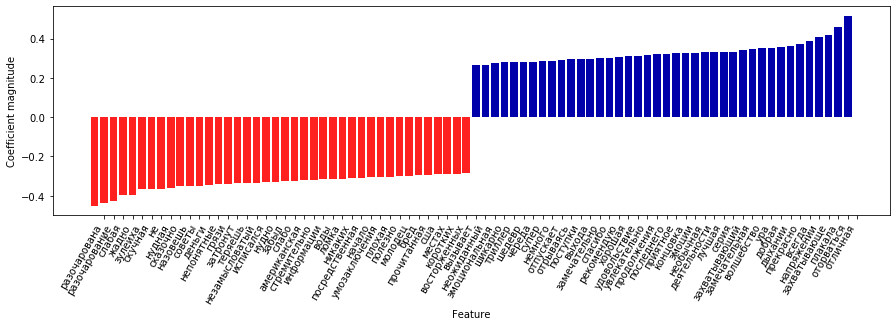

In [26]:

mglearn.tools.visualize_coefficients( grid.best_estimator_.named_steps["logisticregression"].coef_, feature_names, n_top_features=40)

## Мешок слов с n-грамм

In [27]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression()) 
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100],
"tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("Наилучшее значение перекр проверки: {:.2f}".format(grid.best_score_)) 
print("Наилучшие параметры:\n{}".format(grid.best_params_))
resultTMP = pd.DataFrame([['Ngram',grid.score(text_train, y_train)]], columns=result_columns)
result = pd.concat([result, resultTMP])

Наилучшее значение перекр проверки: 0.94
Наилучшие параметры:
{'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 3)}


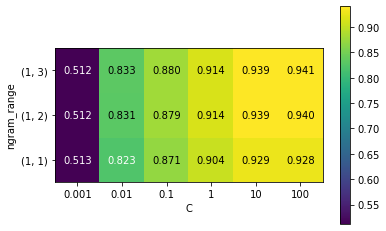

In [28]:
from matplotlib import pyplot as plt
# излекаем значения правильности, найденные в ходе решетчатого поиска
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
# визуализируем теплокарту
heatmap = mglearn.tools.heatmap(
    scores, xlabel="C", ylabel="ngram_range", cmap="viridis", fmt="%.3f", 
    xticklabels=param_grid['logisticregression__C'], 
    yticklabels=param_grid['tfidfvectorizer__ngram_range']) 
plt.colorbar(heatmap)

как видим разница между n=1 и n=3 заметна

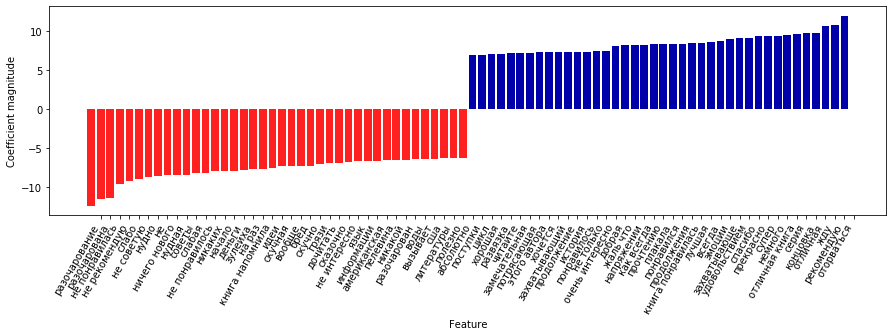

In [29]:
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_ 
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)

In [30]:
mask = np.array([len(feature.split(" ")) for feature in feature_names]) == 3 # визуализируем только 3-граммные признаки 
# mask
mglearn.tools.visualize_coefficients(coef.ravel()[mask],feature_names[mask], n_top_features=40)

### Добавляем лемматизатор

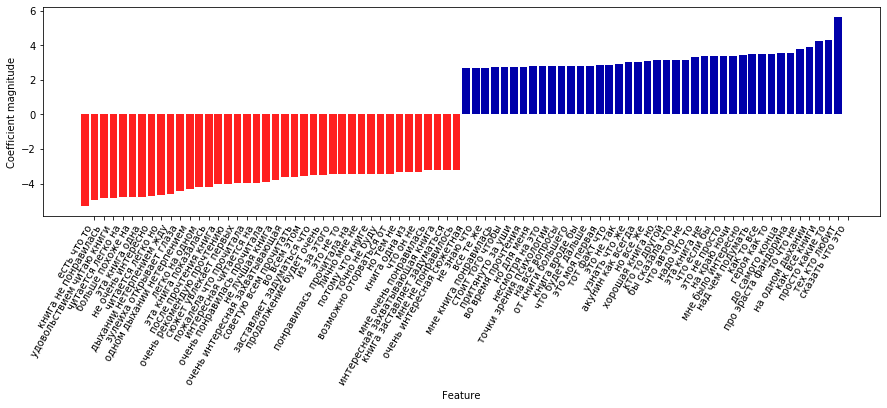

In [31]:
from pymystem3 import Mystem
m = Mystem()
def lemmatize_sentence(text):
    lemmas = m.lemmatize(text)
    return "".join(lemmas).strip()

In [32]:
text_train_lemm = [lemmatize_sentence(doc) for doc in text_train]
text_test_lemm = [lemmatize_sentence(doc) for doc in text_test]

In [33]:
vect_lemm = CountVectorizer(min_df=5).fit(text_train_lemm) 
X_train_lemma = vect_lemm.transform(text_train_lemm)
print("форма X_train_lemma: {}".format(X_train_lemma.shape))

vect = CountVectorizer(min_df=5).fit(text_train) 
X_train = vect.transform(text_train) 
print("форма X_train: {}".format(X_train.shape))

форма X_train_lemma: (13669, 6856)
форма X_train: (13669, 11544)


In [34]:
from sklearn.model_selection import StratifiedShuffleSplit
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.99,train_size=0.01, random_state=0) 
grid = GridSearchCV(LogisticRegression(), param_grid, cv=cv)
# выполняем решетчатый поиск, используя данные, к которым был # применен стандартный CountVectorizer
grid.fit(X_train, y_train)
print("Наилучшее значение перекрестной проверки (стандартный CountVectorizer): {:.3f}".format(grid.best_score_)) # выполняем решетчатый поиск, используя данные, к которым была

resultTMP = pd.DataFrame([['стандартный CountVectorizer',grid.score(X_train, y_train)]], columns=result_columns)
result = pd.concat([result, resultTMP])
# применена лемматизация
grid.fit(X_train_lemma, y_train)
print("Наилучшее значение перекрестной проверки (лемматизация): {:.3f}".format(grid.best_score_))
resultTMP = pd.DataFrame([['Лемматизация',grid.score(X_train_lemma, y_train)]], columns=result_columns)
result = pd.concat([result, resultTMP])


Наилучшее значение перекрестной проверки (стандартный CountVectorizer): 0.718
Наилучшее значение перекрестной проверки (лемматизация): 0.724


In [35]:
result

,name,score
0,Мешок слов,0.945212
0,Min_df,0.940092
0,Стоп слова,0.936679
0,TF-IDF,0.942994
0,Ngram,0.999707
0,стандартный CountVectorizer,0.993269
0,Лемматизация,0.981418


Как видим, самое бодрое решение на тестовых - N-граммы. В нашем случае 3граммы
Далее просто тест модели на тексте

In [36]:
pr = vect_lemm.transform(['Эту книгу я освоила за три часа. Очень хорошо написана, легко усваивается, без замудренных фраз, без отсылок. Всё очень понятно и самое важное - нет воды. Коротко, ясно и по факту. Обожаю такие книги. А, да и картинки есть.  '])
answer=grid.predict(pr)
if(answer[0]):
    print ("Положительный отзыв")
else:
    print ("Отрицательный отзыв")

Положительный отзыв
